# Lesson 03 Assignment - RFM, k-Means

## Task 
Identify customer groupings that visit stores based on customer transaction (sales) data. These groupings are used for targeted promotions. Perform customer segmentation on the provided data.

## Instructions
1. Read dataset
2. Calculate the Recency, Frequency, Monetory for each customer
3. Using K-means algorithm, perform customer segmentation
4. Describe your results

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

## 1. Read dataset

In [2]:
url = 'https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/SuperstoreTransaction.csv'
path = './SuperstoreTransaction.csv'

def load_data(a_url, path, sep = ' '):
    """Return a DataFrame containing a dataset from url or local path."""
    print('Trying to load the data set from a local file if it exists...')
    try:
        data_set = pd.read_csv(path, sep = sep)
    except FileNotFoundError:
        print('\tFile not found, loading from Internet...')
        data_set = pd.read_csv(a_url, sep = sep)
        print('\t\tData loaded from url')
    else:
        print('\tData loaded from local file')
    
    return data_set

store_df = load_data(url, path, sep = ',')

Trying to load the data set from a local file if it exists...
	Data loaded from local file


In [3]:
print(store_df.shape)
store_df.head(2)

(9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


## 2. Calculate the Recency, Frequency, Monetory for each customer

In [4]:
print('Index of Sales column:', list(store_df.columns).index('Sales'))
print('Index of Quantity column:', list(store_df.columns).index('Quantity'))

Index of Sales column: 17
Index of Quantity column: 18


In [5]:
# Convert 'Order Date' to datetime object and inentify the time period
store_df["Order Date"] = pd.to_datetime(store_df["Order Date"], format='%m/%d/%Y')
store_df.head(2)
print("Minimal Date=%s, Maximal Date=%s"%(min(store_df["Order Date"]).strftime("%Y-%m-%d"), \
                                          max(store_df["Order Date"]).strftime("%Y-%m-%d")))

Minimal Date=2014-01-03, Maximal Date=2017-12-30


In [6]:
# The code in this cell is an adaptation of the code in the lab notebook
Start_Date_Obj = dt.datetime.strptime("01/03/2014", "%m/%d/%Y")
End_Date_Obj = dt.datetime.strptime("12/30/2017", "%m/%d/%Y")
# Only consider customers who have activities within the recent 60 days before each Order Date
Time_Window = 60  # days
# Only interested in how many transactions and how much money spent during 7 days before Order Date  
FM_Window = 7  # days for frequency and monetary

order_date = Start_Date_Obj
UserID = []
Orderdate = []
Recency = []
Frequency = []
Monetary_Value = []
Monetary_Quantity = []
day_count = (End_Date_Obj - Start_Date_Obj).days + 1  # Indicator that the process still runs
print('Please wait. The process may take a while. Counting down...')
print(day_count, end = ' ')
while order_date <= End_Date_Obj:
    day_count -= 1
    if day_count % 10 == 0:
        print(day_count, end = ' ')
    window_start = order_date - dt.timedelta(days = Time_Window)
    # Get indices of rows
    mask = (store_df["Order Date"] >= window_start) & (store_df["Order Date"] < order_date)
    # Get the data in [orderdate-60days, orderdate]
    data_orderdate = store_df.loc[mask]
    # Get the ids of users who have activities in [orderdate-60days, orderdate]
    unique_users = list(set(data_orderdate["Customer ID"]))
    FM_Window_Start = order_date - dt.timedelta(days = FM_Window)
    for user in unique_users:
        UserID.append(user)
        Orderdate.append(order_date)
        mask = data_orderdate["Customer ID"] == user
        data_orderdate_user = data_orderdate.loc[mask]
        delta = order_date - max(data_orderdate_user["Order Date"])
        recency = delta.days #Recency, days between order date and last transaction time
        mask = data_orderdate_user["Order Date"] >= FM_Window_Start
        data_orderdate_user_fm = data_orderdate_user.loc[mask]
        # number of transactions the user had in the past week
        frequency = data_orderdate_user_fm.shape[0]
        value = np.sum(data_orderdate_user_fm.iloc[:, 17])  # monetary values
        quantity = np.sum(data_orderdate_user_fm.iloc[:, 18]) # monetary quantity
        Recency.append(recency)
        Frequency.append(frequency)
        Monetary_Value.append(value)
        Monetary_Quantity.append(quantity)
    order_date = order_date + dt.timedelta(days = 1)
# Consolidate all columns into a signle data frame
RFM_Dict = OrderedDict([ ('Customer ID', UserID),
          ('Order Date', Orderdate),
          ('Recency',  Recency),
          ('Frequency', Frequency),
          ('Value', Monetary_Value),
          ('Quantity', Monetary_Quantity)] )
RFM_Frame = pd.DataFrame.from_dict(RFM_Dict)

Please wait. The process may take a while. Counting down...
1458 1450 1440 1430 1420 1410 1400 1390 1380 1370 1360 1350 1340 1330 1320 1310 1300 1290 1280 1270 1260 1250 1240 1230 1220 1210 1200 1190 1180 1170 1160 1150 1140 1130 1120 1110 1100 1090 1080 1070 1060 1050 1040 1030 1020 1010 1000 990 980 970 960 950 940 930 920 910 900 890 880 870 860 850 840 830 820 810 800 790 780 770 760 750 740 730 720 710 700 690 680 670 660 650 640 630 620 610 600 590 580 570 560 550 540 530 520 510 500 490 480 470 460 450 440 430 420 410 400 390 380 370 360 350 340 330 320 310 300 290 280 270 260 250 240 230 220 210 200 190 180 170 160 150 140 130 120 110 100 90 80 70 60 50 40 30 20 10 0 

In [8]:
print(RFM_Frame.shape)
RFM_Frame.head()

(249489, 6)


,Customer ID,Order Date,Recency,Frequency,Value,Quantity
0,DP-13000,2014-01-04,1,1,16.448,2
1,PO-19195,2014-01-05,1,3,288.060,8
2,DP-13000,2014-01-05,2,1,16.448,2
3,PO-19195,2014-01-06,2,3,288.060,8
4,DP-13000,2014-01-06,3,1,16.448,2


In [9]:
# Save rfm results to disk
# RFM_Frame.to_csv('./rfm_frame.csv', index = False)
# RFM_Frame = pd.read_csv('./rfm_frame.csv')
# RFM_Frame.head()

## 3. Using K-means algorithm, perform customer segmentation

In [10]:
# z-normalize the RFM data
scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(RFM_Frame.loc[:, ['Recency', 'Frequency', 'Value', 'Quantity']])
rfm_scaled = scaler.fit_transform(RFM_Frame.loc[:, ['Recency', 'Frequency', 'Value']])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


The following approach has been proposed at <a href=https://towardsdatascience.com/apply-rfm-principles-to-cluster-customers-with-k-means-fef9bcc9ab16>towardsdatascience.com</a>. I only made minor modifications and added some comments.

In [11]:
# Determine how many clusters I want
wcss = []  # Create a list of within-cluster sums of squares (WCSS)
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

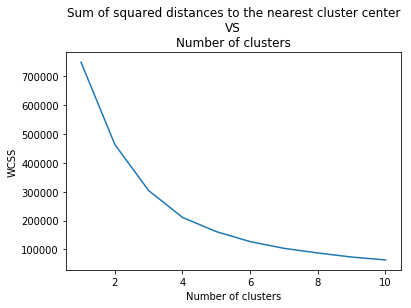

In [12]:
plt.plot(range(1,11), wcss)
plt.title('Sum of squared distances to the nearest cluster center\nVS\nNumber of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The point where the line starts to do a soft descent is the optimal number of clusters. This seems to be 4.

In [13]:
# Perform k-Means based on the 'Recency, Frequency, Value' array
num_clusters = 4
kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 0)
clusters = kmeans.fit_predict(rfm_scaled)

In [14]:
# Clusters assigned to each customer
RFM_Frame['clusters'] = clusters
RFM_Frame.head()

,Customer ID,Order Date,Recency,Frequency,Value,Quantity,clusters
0,DP-13000,2014-01-04,1,1,16.448,2,0
1,PO-19195,2014-01-05,1,3,288.060,8,1
2,DP-13000,2014-01-05,2,1,16.448,2,0
3,PO-19195,2014-01-06,2,3,288.060,8,1
4,DP-13000,2014-01-06,3,1,16.448,2,0


Text(0.5, 0, 'Monetary')

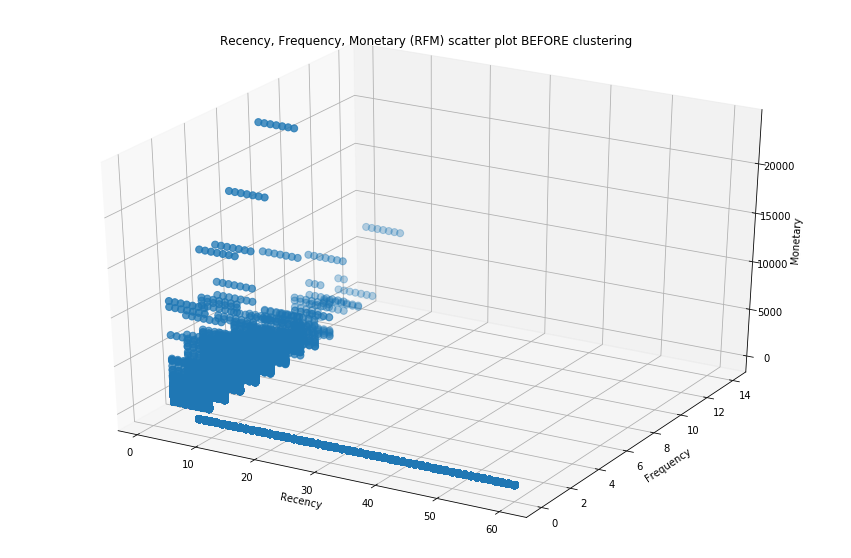

In [15]:
# Plot data points before clustering
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(RFM_Frame.Recency, RFM_Frame.Frequency, RFM_Frame.Value, s = 50)

ax.set_title('Recency, Frequency, Monetary (RFM) scatter plot BEFORE clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

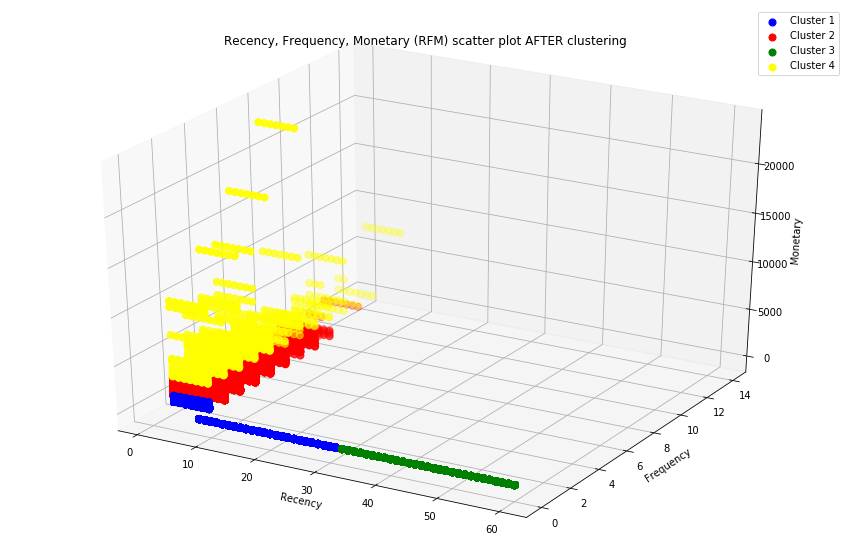

In [16]:
fig = plt.figure(figsize = (15,10))
dx = fig.add_subplot(111, projection = '3d')
colors = ['blue', 'red', 'green', 'yellow']

for i in range(0, 4):
    dx.scatter(RFM_Frame[RFM_Frame.clusters == i].Recency, 
               RFM_Frame[RFM_Frame.clusters == i].Frequency, 
               RFM_Frame[RFM_Frame.clusters == i].Value, 
               c = colors[i], 
               label = 'Cluster ' + str(i + 1), 
               s = 50)

dx.set_title('Recency, Frequency, Monetary (RFM) scatter plot AFTER clustering')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

In [17]:
# Select customer data by clusters
c1, c2, c3, c4 = [RFM_Frame[RFM_Frame.clusters == i] for i in range(4)]

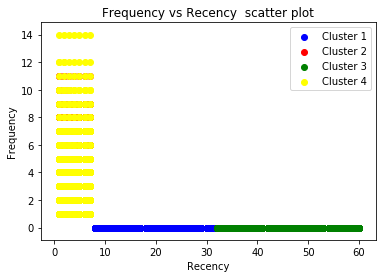

In [18]:
plt.scatter(c1.Recency, c1.Frequency, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Frequency, c = 'red', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Frequency, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Frequency, c = 'yellow', label = 'Cluster 4')

plt.title('Frequency vs Recency  scatter plot')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

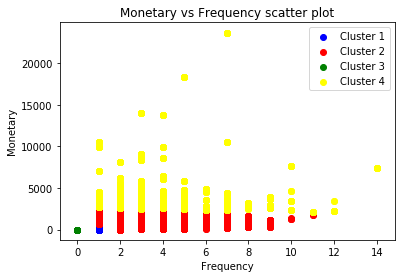

In [19]:
plt.scatter(c1.Frequency, c1.Value, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Frequency, c2.Value, c = 'red', label = 'Cluster 2')
plt.scatter(c3.Frequency, c3.Value, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Frequency, c4.Value, c = 'yellow', label = 'Cluster 4')

plt.title('Monetary vs Frequency scatter plot')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

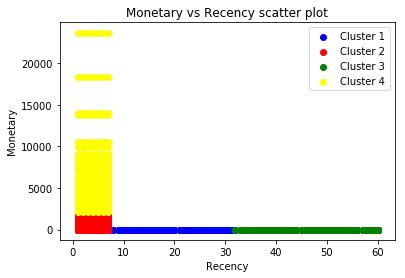

In [20]:
plt.scatter(c1.Recency, c1.Value, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Value, c = 'red', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Value, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Value, c = 'yellow', label = 'Cluster 4')

plt.title('Monetary vs Recency scatter plot')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

## 4. Describe your results

I applied the k-means algorithm with the number of clusters set at 4 to an array of values 'Recency', 'Frequency', and 'Monetary' calculated for a customer transactions dataset.

The algorithm seperated the customers into four groupings which I can summarize as follows:

|   cluster      | Recency      | Frequency  | Monetary |
| ------------- |:-------------:| ----------:|---------:|
| 1 (blue)      |  L-M          |   Low      | Low      | 
| 2 (red)       |  Low         |   L-M-H    |   Medium |
| 3 (green)     | High         |    Low     |   Low    |
| 4 (yellow)    |   Low         | L-M-H      |    M-H   |

I would interpret this result as indicating that customers in group 4 (yellow) and to a lesser extent group 2 (red) are the most attractive customers because of the higher value and lower recency of their transactions.